# Catcher Framing

## 7.2 Acquiring Pitch-Level Data

Reading data from the 2022 season:

For Statcast data, I am using the `pybaseball` library to pull data used in catcher framing analysis. This library is Python equivalent of R's `baseballr` package used in the book.

- **GitHub:** [github.com/jldbc/pybaseball](https://github.com/jldbc/pybaseball)

Pulling 2022 Statcast data

In [1]:
import pandas as pd
import pybaseball as pyb
from pybaseball import cache

# pybaseball docs recommend adding cache to avoid redownloading
cache.enable()

sc2022 = pyb.statcast(start_dt='2022-03-01', end_dt='2022-11-30')

def categorize_outcome(description):
    balls = ['ball', 'blocked_ball', 'pitchout', 'hit_by_pitch']
    swings = ['swinging_strike', 'swinging_strike_blocked', 'foul', 
              'foul_bunt', 'foul_tip', 'hit_into_play', 'missed_bunt']
    if description in balls:
        return 'ball'
    elif description in swings:
        return 'swing'
    elif description == 'called_strike':
        return 'called_strike'
    else:
        return None

sc2022['Outcome'] = sc2022['description'].apply(categorize_outcome)

sc2022['Home'] = (sc2022['inning_topbot'] == 'Bot').astype(int)

sc2022['Count'] = sc2022['balls'].astype(str) + '-' + sc2022['strikes'].astype(str)

sc2022_taken = sc2022[sc2022['Outcome'] != 'swing'].copy()

print(f"Total pitches: {len(sc2022):,}")
print(f"Taken pitches: {len(sc2022_taken):,}")

This is a large query, it may take a moment to complete
Skipping offseason dates
Skipping offseason dates


100%|██████████| 246/246 [00:17<00:00, 14.05it/s]
/Users/bobbyking/anaconda3/envs/baseball/lib/python3.11/site-packages/pybaseball/statcast.py:85: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  final_data = pd.concat(dataframe_list, axis=0).convert_dtypes(convert_string=False)


Total pitches: 775,330
Taken pitches: 401,507


Data is filtered for only "taken" pitches (balls and called strikes) because catcher framing only affects umpire judgment on pitches the batter does not swing at.


Create 50,000 pitch sample of 2022 data and save output for analysis.  I used parquet over CSV in this case to reduce file size

In [2]:
sc2022_taken_sample = sc2022_taken.sample(n=50000, random_state=42)

print(f"Total pitches: {len(sc2022):,}")
print(f"Taken pitches: {len(sc2022_taken):,}")
print(f"Sample size for analysis: {len(sc2022_taken_sample):,}")

sc2022_taken_sample.to_parquet('../data/statcast_2022_sample.parquet', index=False)


Total pitches: 775,330
Taken pitches: 401,507
Sample size for analysis: 50,000


## 7.3 Where Is the Strike Zone?

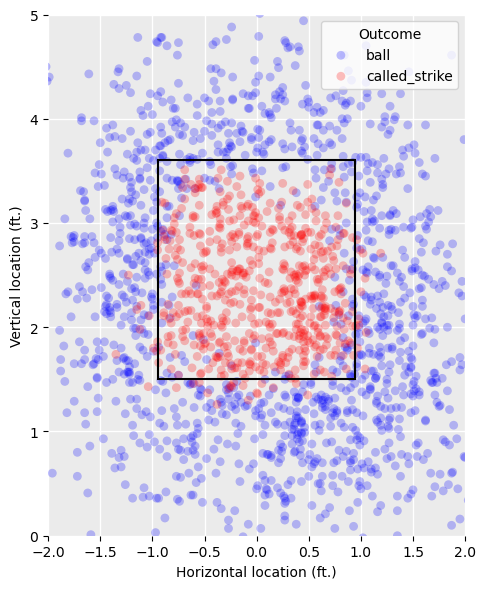

In [4]:
import matplotlib.pyplot as plt
import sys
sys.path.append('../')
from src.plotting_utils import add_strike_zone

# Further sample only 2000 rows for plotting
taken = sc2022_taken.sample(n=2000, random_state=42)

fig, ax = plt.subplots(figsize=(8, 6))

ax.set_facecolor('#EBEBEB')

colors = {'ball': 'blue', 'called_strike': 'red'}

for outcome in ['ball', 'called_strike']:
    subset = taken[taken['Outcome'] == outcome]
    ax.scatter(
        subset['plate_x'], 
        subset['plate_z'],
        c=colors[outcome],
        alpha=0.25,
        s=40,
        label=outcome,
        edgecolors='none'
    )

add_strike_zone(ax, facecolor='none', linewidth=1.5)

ax.grid(True, color='white', linewidth=1, zorder=0)
ax.set_axisbelow(True)

for spine in ax.spines.values():
    spine.set_visible(False)

ax.set_xlabel('Horizontal location (ft.)')
ax.set_ylabel('Vertical location (ft.)')
ax.set_xlim(-2, 2)
ax.set_ylim(0, 5)

ax.set_aspect('equal')

ax.legend(title='Outcome', loc='upper right', frameon=True, framealpha=0.8)

plt.tight_layout()
plt.show()

Many pitches outside the strike zone are called strikes. Catcher framing influences these borderline calls.

Compute the probability that a pitch taken in each Statcast zone will be called a strike

In [9]:
zones = taken.groupby('zone').agg(
    N=('zone', 'size'),
    right_edge=('plate_x', lambda x: min(1.5, x.max())),
    left_edge=('plate_x', lambda x: max(-1.5, x.min())),
    top_edge=('plate_z', lambda x: min(5, x.quantile(0.95))),
    bottom_edge=('plate_z', lambda x: max(0, x.quantile(0.05))),
    strike_pct=('Outcome', lambda x: (x == 'called_strike').sum() / len(x)),
    plate_x=('plate_x', 'mean'),
    plate_z=('plate_z', 'mean')
).reset_index()

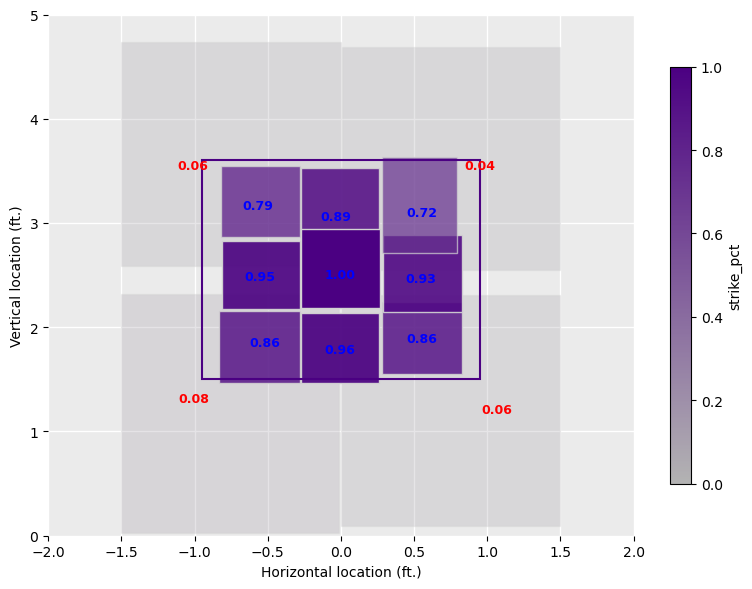

In [11]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.colors import LinearSegmentedColormap, Normalize

fig, ax = plt.subplots(figsize=(8, 6))

ax.set_facecolor('#EBEBEB')

cmap = LinearSegmentedColormap.from_list('gray_to_blue', ['#B3B3B3', '#4B0082'])
norm = Normalize(vmin=0, vmax=1)

zones_sorted = zones.sort_values('N', ascending=False)

for _, row in zones_sorted.iterrows():
    rect = Rectangle(
        (row['left_edge'], row['bottom_edge']),
        width=row['right_edge'] - row['left_edge'],
        height=row['top_edge'] - row['bottom_edge'],
        facecolor=cmap(norm(row['strike_pct'])),
        edgecolor='lightgray',
        alpha=max(0.3, row['strike_pct']),
        linewidth=1,
        zorder=1
    )
    ax.add_patch(rect)

for _, row in zones.iterrows():
    text_color = 'red' if row['strike_pct'] < 0.5 else 'blue'
    ax.text(
        row['plate_x'], 
        row['plate_z'],
        f"{row['strike_pct']:.2f}",
        ha='center', 
        va='center',
        fontsize=9,
        color=text_color,
        fontweight='bold',
        zorder=3
    )

add_strike_zone(ax, facecolor='none', edgecolor='#4B0082', linewidth=1.5)
ax.patches[-1].set_zorder(2)

ax.grid(True, color='white', linewidth=1, zorder=0)
ax.set_axisbelow(True)

for spine in ax.spines.values():
    spine.set_visible(False)

ax.set_xlabel('Horizontal location (ft.)')
ax.set_ylabel('Vertical location (ft.)')
ax.set_xlim(-2, 2)
ax.set_ylim(0, 5)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = plt.colorbar(sm, ax=ax, label='strike_pct', shrink=0.8)

plt.tight_layout()
plt.show()

- Center of zone: Near-certain strike calls (89-100%)
- Corners: Lower certainty (72-86%) — potential for catcher framing impact
- Outside zone: Strike probability drops to 4-8%